In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.previous:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

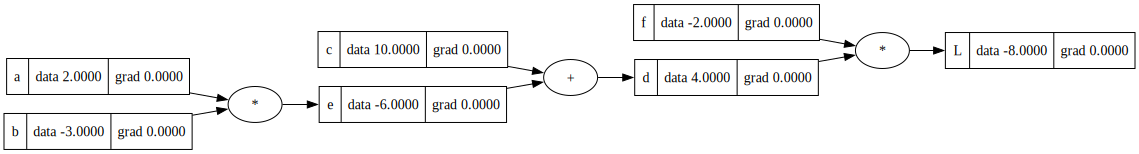

In [39]:
class Value:
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.previous = set(children)
        self.op = op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+", )
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out =  Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), (self,), 'tanh')
        def _backward():
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward
        return out 
    
    def backward(self):
        sorted = []
        visited = set()
        def dfs(value):
            if value not in visited:
                visited.add(value)
                for child in value.previous:
                    dfs(child)
                sorted.append(value)
        dfs(self)
        self.grad = 1.0
        for value in reversed(sorted):
          value._backward()
        
        

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'

draw_dot(L)


L = d * f

dL/dd =? f

(f(x + h) - f(x)) / h

((d + h) * f - d * f) / h
(d * f + h * f - d * f) / h
h * f / h
f

L = d * f     d = e + c   f = -2
dL/dc = ?

Applying rule of chain:
dL/dc = dL/dd * dd/dc

Given
dd/dc = ?
d = c + e
dd/dc = 1.0
dd/de = 1.0

Then:
dL/dc = f * 1.0 = -2.0

dL/de = -2.0

dL/da = de/da * dd/de * dL/dd
dL/da = b * 1 * f = b * f = 6

dL/db = de/db * dd/de * dL/dd
dL/da = a * 1 * f = a * f = -4

In [4]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

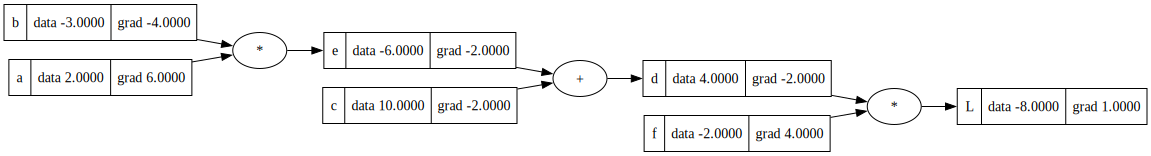

In [5]:
draw_dot(L)

Now we want to nudge the inputs to try to make L to go up. We are going to change it in the direction of the gradient, increasing it by a small step amount.

In [6]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [27]:
def manual_diff():
  h = 0.0000001
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0 + h, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d  * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

manual_diff()

-3.9999999934536845


Now we are going to manually backpropagate through a neuron. A neuron is modeled as a sum of inputs multiplied by a weight with a bias, indicating how easily the neuron is triggered. An activation function is applied to it and that's the output of the function.

In [40]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

Now we have to fill in all the gradients by calculating all the derivatives. We care most about the derivatives of the w since that's what we would be changing when "learning".

In [41]:
o.grad = 1.0

# Now backpropagate through tanh. What's the derivative?
# o = tanh(n)
# do/dn = ?
# do/dn = 1 - tanh(n)**2 = 1 - o**2 = 1 - o.data**2

n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

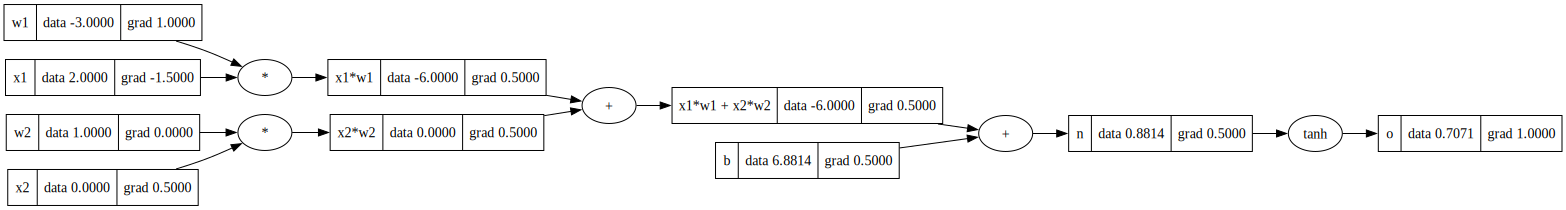

In [42]:
draw_dot(o)

We don't want to do this manually. So let's extend the value object to calculate it for us.

In [11]:
o.grad = 1.0

In [12]:
o._backward()

In [13]:
n._backward()

In [14]:
b._backward()

In [15]:
x1w1x2w2._backward()

In [16]:
x1w1._backward()

In [17]:
x2w2._backward()

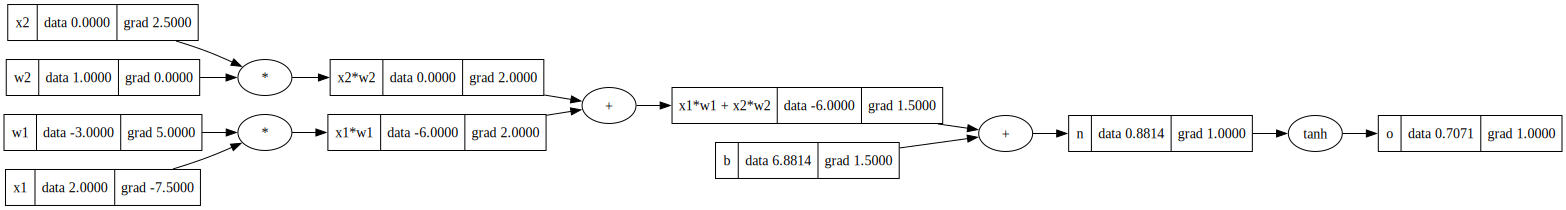

In [18]:
draw_dot(o)

If we want to run automatically backward on each node we must perform a topological sort and then go through each node and run backward. This is because we can't run backward before all the previous ones were run.

In [19]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [20]:
sorted = []
visited = set()
def dfs(value):
  if value not in visited:
    visited.add(value)
    for child in value.previous:
      dfs(child)
    sorted.append(value)

dfs(o)
sorted

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

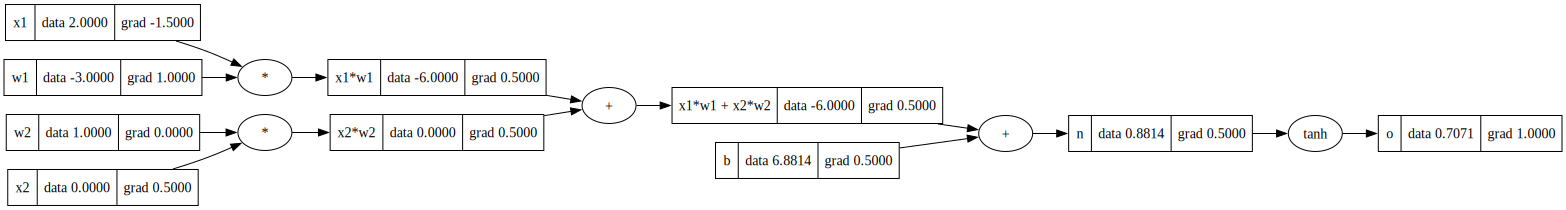

In [21]:
o.grad = 1.0
for value in reversed(sorted):
  value._backward()

draw_dot(o)


After adding the backward logic to the Value class, let's run it again:

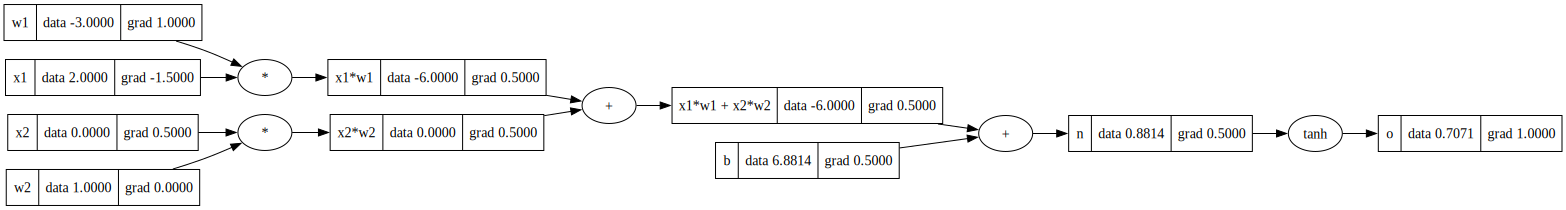

In [22]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)